In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2


In [5]:
# Fungsi untuk memuat dataset
def scan_and_load_images(base_folder, target_size=(64, 64)):
    # Data generator dengan rescaling saja (tanpa augmentasi)
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        validation_split=0.2  # 20% untuk validasi
    )

    # Generator untuk training
    train_generator = datagen.flow_from_directory(
        base_folder, 
        target_size=target_size,
        color_mode='grayscale',
        batch_size=32,
        class_mode='categorical',  # Multi-class classification
        subset='training',
        shuffle=True
    )

    # Generator untuk validasi
    validation_generator = datagen.flow_from_directory(
        base_folder,
        target_size=target_size,
        color_mode='grayscale',
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    return train_generator, validation_generator


In [6]:
# Path ke dataset
dataset_path = 'D:\\projek\\FIX\\drowsiness-detection\\new_test_processing'

In [7]:
# Panggil fungsi untuk memuat data
train_generator, validation_generator = scan_and_load_images(dataset_path)

# Print label mapping
print("Class indices:", train_generator.class_indices)


Found 2363 images belonging to 3 classes.
Found 589 images belonging to 3 classes.
Class indices: {'mengantuk': 0, 'menguap': 1, 'tidak_mengantuk': 2}


In [17]:
# Model MobileNet
def build_mobilenet_model(input_shape, num_classes):
    # Gunakan MobileNet tanpa pre-trained weights
    base_model = MobileNet(
        weights=None,  # Tidak menggunakan pretrained weights
        include_top=False,
        input_shape=input_shape
    )
    # Tambahkan head model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Semua layer bisa dilatih karena tidak ada pretrained weights
    for layer in base_model.layers:
        layer.trainable = True

    return model


In [18]:
# Input shape dan jumlah kelas
input_shape = (64, 64, 1)
num_classes = 3  # mengantuk, menguap, tidak_mengantuk

In [19]:
# Inisialisasi model
model = build_mobilenet_model(input_shape, num_classes)

In [20]:
# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [21]:
# Callback untuk early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [22]:
# Training model
print("\n=== Training Model ===")
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping]
)



=== Training Model ===
Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 84s 593ms/step - accuracy: 0.3287 - loss: 4.5212 - val_accuracy: 0.4160 - val_loss: 3.2005
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 43s 576ms/step - accuracy: 0.4436 - loss: 3.7031 - val_accuracy: 0.4160 - val_loss: 3.0948
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 43s 581ms/step - accuracy: 0.5294 - loss: 3.2139 - val_accuracy: 0.4160 - val_loss: 2.9479
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 553ms/step - accuracy: 0.5944 - loss: 2.8282 - val_accuracy: 0.4160 - val_loss: 2.7062
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 528ms/step - accuracy: 0.6297 - loss: 2.4566 - val_accuracy: 0.4160 - val_loss: 2.6440
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 527ms/step - accuracy: 0.6886 - loss: 2.1744 - val_accuracy: 0.4160 - val_loss: 2.5346
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 40s 536ms/step - accuracy: 0.7313 - loss: 1.9252 - val_accuracy: 0.4160 - val_loss: 2.5489
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 528ms/step - accuracy: 


=== Evaluasi Model ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.7750 - loss: 0.5736
Validation Loss: 0.5074
Validation Accuracy: 0.7623
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step
mengantuk: Optimal Threshold = 0.5471
menguap: Optimal Threshold = 0.0609
tidak_mengantuk: Optimal Threshold = 0.9043


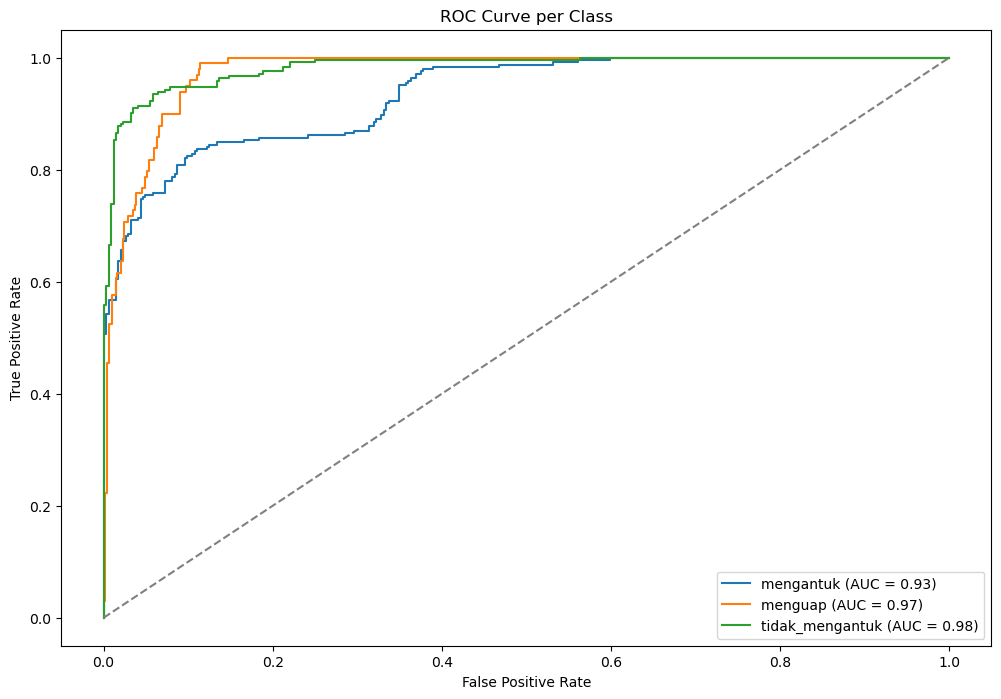

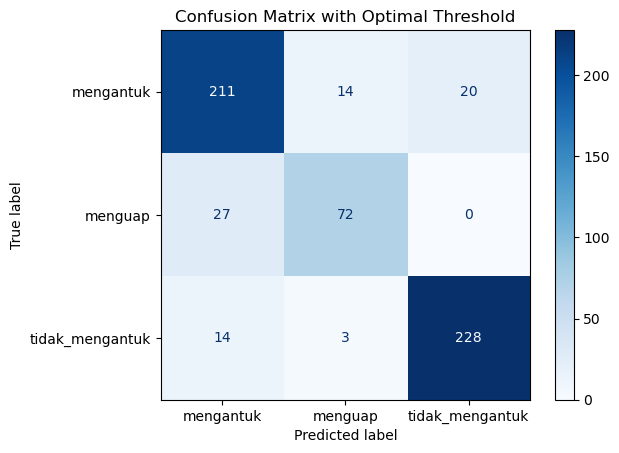


Classification Report (Optimal Threshold):
                 precision    recall  f1-score   support

      mengantuk       0.84      0.86      0.85       245
        menguap       0.81      0.73      0.77        99
tidak_mengantuk       0.92      0.93      0.92       245

       accuracy                           0.87       589
      macro avg       0.86      0.84      0.85       589
   weighted avg       0.87      0.87      0.87       589



In [15]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc

# Evaluasi dengan generator validasi
print("\n=== Evaluasi Model ===")
evaluation = model.evaluate(validation_generator)
print(f"Validation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]:.4f}")

# Confusion Matrix
validation_generator.reset()
y_probs = model.predict(validation_generator)
y_pred = np.argmax(y_probs, axis=1)
y_true = validation_generator.classes

# ROC Curve dan Optimal Threshold untuk setiap kelas
optimal_thresholds = []
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(train_generator.class_indices.keys()):
    fpr, tpr, thresholds = roc_curve((y_true == i).astype(int), y_probs[:, i])
    roc_auc = auc(fpr, tpr)

    # Cari threshold optimal
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds.append(optimal_threshold)

    # Plot ROC Curve
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    print(f"{class_name}: Optimal Threshold = {optimal_threshold:.4f}")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class')
plt.legend(loc='lower right')
plt.show()

# Update Prediksi Menggunakan Optimal Threshold
y_pred_optimal = np.zeros_like(y_probs)

# Terapkan threshold optimal untuk setiap kelas
for i, threshold in enumerate(optimal_thresholds):
    y_pred_optimal[:, i] = (y_probs[:, i] > threshold).astype(int)

# Pilih kelas dengan skor tertinggi setelah thresholding
y_pred_optimal_class = np.argmax(y_pred_optimal, axis=1)

# Confusion Matrix dengan threshold optimal
cm_optimal = confusion_matrix(y_true, y_pred_optimal_class)
disp_optimal = ConfusionMatrixDisplay(confusion_matrix=cm_optimal, display_labels=list(train_generator.class_indices.keys()))
disp_optimal.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix with Optimal Threshold")
plt.show()

# Classification Report dengan threshold optimal
print("\nClassification Report (Optimal Threshold):")
print(classification_report(y_true, y_pred_optimal_class, target_names=list(train_generator.class_indices.keys())))


In [12]:
model.save('cnn_model_mobilenet.h5')
print("Model telah disimpan dalam format .h5")

Model telah disimpan dalam format .h5


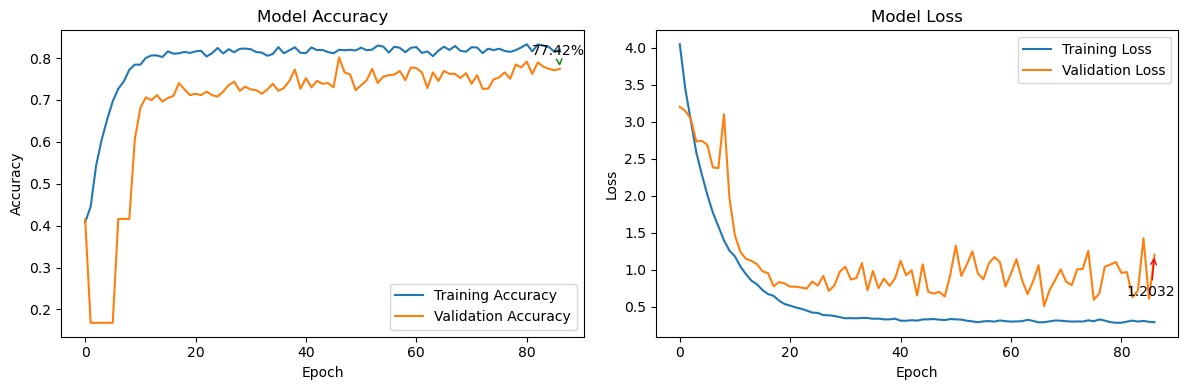

In [16]:
# Visualisasi hasil training
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Tambahkan anotasi akurasi validasi terakhir
final_val_accuracy = history.history['val_accuracy'][-1]
plt.annotate(f'{final_val_accuracy * 100:.2f}%', 
             xy=(len(history.history['val_accuracy']) - 1, final_val_accuracy), 
             xytext=(-20, 10), textcoords='offset points', 
             arrowprops=dict(arrowstyle='->', color='green'))

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Tambahkan anotasi loss validasi terakhir
final_val_loss = history.history['val_loss'][-1]
plt.annotate(f'{final_val_loss:.4f}', 
             xy=(len(history.history['val_loss']) - 1, final_val_loss), 
             xytext=(-20, -30), textcoords='offset points', 
             arrowprops=dict(arrowstyle='->', color='red'))

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [73]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from imutils import face_utils
import dlib

# Load model
model_path = "cnn_model_mobilenet.h5"
try:
    model = load_model(model_path)
    print(f"Model berhasil dimuat dari: {model_path}")
except Exception as e:
    print(f"Gagal memuat model: {e}")
    exit()

# Load predictor untuk landmark wajah
predictor_path = 'data/shape_predictor_68_face_landmarks.dat'
if not os.path.exists(predictor_path):
    print(f"File landmark predictor tidak ditemukan: {predictor_path}")
    exit()

predictor = dlib.shape_predictor(predictor_path)

def preprocess_eye_mouth(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to read image: {image_path}")
        return None

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah
    detector = dlib.get_frontal_face_detector()
    faces = detector(img_gray, 1)
    if len(faces) == 0:
        print(f"No face detected in image: {image_path}")
        return None

    for face in faces:
        rect = dlib.rectangle(face.left(), face.top(), face.right(), face.bottom())
        landmarks = predictor(img_gray, rect)
        landmarks = face_utils.shape_to_np(landmarks)

        # Ambil mata kiri dan kanan
        left_eye_points = landmarks[36:42]

        right_eye_points = landmarks[42:48]
        mouth_points = landmarks[48:68]

        # Ekstrak bounding box untuk mata dan mulut
        def crop_roi(points):
            (x_min, y_min) = points.min(axis=0)
            (x_max, y_max) = points.max(axis=0)
            roi = img_gray[y_min:y_max, x_min:x_max]
            roi_resized = cv2.resize(roi, (64, 64), interpolation=cv2.INTER_CUBIC) / 255.0
            return np.expand_dims(roi_resized, axis=-1)  # Tambahkan channel untuk grayscale

        left_eye = crop_roi(left_eye_points)
        right_eye = crop_roi(right_eye_points)
        mouth = crop_roi(mouth_points)

        # Gabungkan mata kiri, kanan, dan mulut dalam satu batch
        return {
            "left_eye": np.expand_dims(left_eye, axis=0),
            "right_eye": np.expand_dims(right_eye, axis=0),
            "mouth": np.expand_dims(mouth, axis=0),
        }

# Daftar gambar untuk prediksi
image_paths = ["D:\\pcv\\test data\\nguap.jpg", "D:\\pcv\\test data\\mengantuk 4.jpeg"]

# Perbaharui proses prediksi
for image_path in image_paths:
    if not os.path.exists(image_path):
        print(f"Gambar tidak ditemukan: {image_path}")
        continue

    rois = preprocess_eye_mouth(image_path)
    if rois is not None:
        # Prediksi untuk masing-masing ROI
        left_eye_pred = model.predict(rois["left_eye"])[0]
        right_eye_pred = model.predict(rois["right_eye"])[0]
        mouth_pred = model.predict(rois["mouth"])[0]

        # Hitung rata-rata prediksi sebagai hasil akhir
        final_prediction = (left_eye_pred + right_eye_pred + mouth_pred) / 3

        # Tentukan kelas dan confidence berdasarkan probabilitas maksimum
        class_index = np.argmax(final_prediction)
        confidence = final_prediction[class_index]
        class_labels = ["Mengantuk", "Menguap", "Tidak Mengantuk"]
        label = class_labels[class_index]

        # Output hasil
        print(f"Image: {image_path}")
        print(f"Predicted Label: {label} (Confidence: {confidence:.2f})\n")
    else:
        print(f"Gagal memproses gambar: {image_path}\n")

print(f"Final Prediction for {image_path}: {final_prediction}")



Model berhasil dimuat dari: cnn_model_mobilenet.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image: D:\pcv\test data\nguap.jpg
Predicted Label: Tidak Mengantuk (Confidence: 0.78)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Image: D:\pcv\test data\mengantuk 4.jpeg
Predicted Label: Mengantuk (Confidence: 0.85)

Final Prediction for D:\pcv\test data\mengantuk 4.jpeg: [0.8477785  0.13948785 0.01273378]
